In [1]:
from re import X
from socket import create_server
from statistics import median
import sys
sys.path.append("../implementing-flows")

import numpy as np
import random
import math
import numdifftools as nd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import functions
import cProfile, pstats
import time
import SampleGenerator as sg
import MMDFunctions 
import torch

c:\Users\redce\Documents\cs-stuff\implementing-flows\.venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
random.seed(0)
np.random.seed(0)

e = math.e
pi = math.pi

In [3]:
def norm(i):
    return np.sqrt(sum(np.square(i)))

In [4]:
def GradientApprox(VariableList):
    Gradient = []
    delta = 1e-8
    for f in range(NumFs):
        GradientX = ((PotentialFsVectorized[f](VariableList + [delta/2, 0]) - (PotentialFsVectorized[f](VariableList - [delta/2, 0])))/delta)
        GradientY = ((PotentialFsVectorized[f](VariableList + [0, delta/2]) - (PotentialFsVectorized[f](VariableList - [0, delta/2])))/delta)
        Gradient.append(np.squeeze(np.transpose([GradientX, GradientY])))

    return Gradient

In [5]:
# REVISED:
def BetaNewton(): # Newton's method (Experimental)
    xSummationGradient = np.zeros(NumFs)
    ySummationGradient = np.zeros(NumFs)
    G = np.zeros(NumFs)
    xSummationGradient = [sum(PotentialFsVectorized[f](MixtureSample)) for f in range(NumFs)]
    ySummationGradient = [sum(PotentialFsVectorized[f](CrescentSample)) for f in range(NumFs)]
    G = [(1/len(MixtureSample)) * xSummationGradient[k] - (1/len(CrescentSample)) * ySummationGradient[k] for k in range(NumFs)]
    G = np.array(G)
    yHessian = np.zeros([NumFs,NumFs])
    F_gradient = GradientApprox(CrescentSample)
    for m in range(0, NumFs):
        for n in range(0, NumFs):
            yHessian[m][n] = sum((F_gradient[m]*F_gradient[n]).sum(axis = 1))
    
    H = np.multiply(yHessian, 1/len(CrescentSample))
    HInverseNeg = (-1) * np.linalg.inv(H)
    Beta = np.matmul(HInverseNeg, G)
    LearningRate = 0.5 # Not sure how to choose this value
    ParameterList = [1, LearningRate/norm(Beta)]
    return Beta * min(ParameterList) # min(ParameterList) can be understood as similar to the "Proportion" in gradient descent

In [6]:
def u(x):
    F_eval = [(PotentialFs[f](x)) for f in range(NumFs)]
    return (((x[0] ** 2) + (x[1] ** 2)) / 2) + np.dot(Beta, F_eval)

In [7]:
def uVectorized(x):
    F_eval = [PotentialFsVectorized[f](x) for f in range(NumFs)]
    return ((np.square(x[:,0])) + (np.square(x[:,1])))/2 + (np.transpose(F_eval) * Beta).sum(axis = 1)

In [8]:
def uConjugate(y):
    ConvexVector = ((MixtureSample * y)[:,0] + (MixtureSample * y)[:,1]) - uVectorized(MixtureSample)
    return max(ConvexVector)

In [9]:
def uConjugateVec(y):
    ConvexMatrix = np.array(np.matmul(y, np.transpose(MixtureSample))) - uVectorized(MixtureSample)
    return ConvexMatrix.max(axis = 1)

In [10]:
def D():

    xSummation = sum(uVectorized(MixtureSample))
    ySummation = sum(uConjugateVec(CrescentSample))

    LL = 1/len(MixtureSample) * xSummation + 1 / \
        len(CrescentSample) * ySummation

    return LL

In [11]:
def SamplesUpdate(OldMixtureSample):
    NewMixtureSample = []
    F_eval_x = [0,0,0,0,0]
    F_eval_y = [0,0,0,0,0]
    for f in range(0,NumFs):
        gradient = GradientApprox(OldMixtureSample)[f]
        F_eval_x[f] = (gradient[:,0])
        F_eval_y[f] = (gradient[:,1])
    F_eval_x = np.array(F_eval_x)
    F_eval_y= np.array(F_eval_y)

    xVal = OldMixtureSample[:,0]
    yVal = OldMixtureSample[:,1] + (np.multiply(np.transpose(F_eval_y), Beta)).sum(axis = 1)

    NewMixtureSample = np.array([xVal, yVal])
    NewMixtureSample = np.transpose(NewMixtureSample)

    return NewMixtureSample

In [12]:
def MixtureSampleGenerator():
    mean1 = [1, 2]
    cov1 = [[0.5, 0], [0, 0.5]]
    mean2 = [2, 1]
    cov2 = [[0.5, 0], [0, 0.5]]
    x = np.random.multivariate_normal(mean1, cov1, 500)
    y = np.random.multivariate_normal(mean2, cov2, 500)
    MixtureSample = []
    for i in range(500):
        RandomSelector = random.random()
        if RandomSelector > 0.7:
            MixtureSample.append(x[i])
        else:
            MixtureSample.append(y[i])
    MixtureSample = np.array(MixtureSample)
    return MixtureSample

In [13]:
def StandardNormalGenerator():
    Sample = []
    x = np.random.standard_normal(500)
    y = np.random.standard_normal(500)
    for i in range(500):
        Sample.append([x[i], y[i]])
    return Sample

In [14]:
def SigCalculation(X,Y):
    Z = X + Y
    DistList = []
    for i in range(len(Z)):
        for j in range(len(Z)):
            DistList.append(functions.distance(Z[i],Z[j]))

    return median(DistList)

In [15]:
#------------------------------------------------------------------ TESTING (change to heatmap, add animtation)------------------------------------------------------------
CrescentSample = sg.JointSampleGenerator()
MixtureSample = sg.IndependentCouplingGenerator(CrescentSample, len(CrescentSample))
CenterGeneratorList = CrescentSample
  
steps = [MixtureSample]

PotentialFs = [functions.Giulio_F(alpha=1),
                functions.Gaussian_F(alpha=1, constant=1),
                functions.Multiquadric_F(alpha=1, constant=1),
                functions.InverseQuadratic_F(alpha=1, constant=1),
                functions.InverseMultiquadric_F(alpha=1, constant=1)]
NumFs = len(PotentialFs)
PotentialFsVectorized = [functions.Giulio_F_Vectorized(alpha = 1),
                        functions.Gaussian_F_Vectorized(alpha=1, constant=0),
                        functions.Multiquadric_F_Vectorized(alpha=1, constant=0),
                        functions.InverseQuadratic_F_Vectorized(alpha=1, constant=0),
                        functions.InverseMultiquadric_F_Vectorized(alpha=1, constant=0)]


DValue = 0
Iteration = 0
Beta = 0

(-1.0, 6.0)

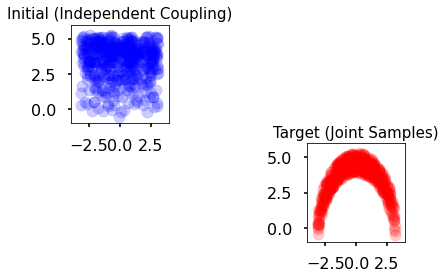

In [16]:
plt.rc('axes', titlesize=15) 

plt.subplot(2,3,1)
plt.title("Initial (Independent Coupling)")
plt.scatter(*zip(*MixtureSample), color = 'b', alpha = 0.2)
plt.xlim(-4, 4)
plt.ylim(-1, 6)
CenterList = []

plt.subplot(2,3,6)
plt.title("Target (Joint Samples)")
plt.scatter(*zip(*CrescentSample), color = 'r', alpha = 0.2)
plt.xlim(-4, 4)
plt.ylim(-1, 6)

In [17]:
# Profiling code
profiler = cProfile.Profile()
profiler.enable()
SamplesSaved = []
for i in range(1000): # Maybe there is a problem of overfitting
    #print("Iteration " + str(i))
    Iteration += 1
    if Iteration >= 10:
        CenterGeneratorList = MixtureSample + CrescentSample
    CenterList = []
    # DistanceMixture = np.zeros([500,5])
    # DistanceTarget = np.zeros([500,5])
    for f in range(0,NumFs):
        c = CenterGeneratorList[random.randint(0, len(CenterGeneratorList) - 1)]
        CenterList.append(c)
        PotentialFs[f].setCenter(c)
        PotentialFsVectorized[f].setCenter(c)
    OldBeta = Beta
    Beta = BetaNewton()
    OldD = DValue
    DValue = D()
    print(DValue)
    MixtureSample = SamplesUpdate(MixtureSample)
    if i == 249 or i == 499 or i == 749 or i == 999:
        SamplesSaved.append(MixtureSample)
    steps.append(MixtureSample)

16.76568270978042
16.86474081493342
16.956272292366435
17.017445551207828
17.032712529945552
17.157025563605462
17.03723741847567
17.071481704620467
16.928360957199722
16.93475617735313
16.9347560257306
16.93459563746349
16.936266497470264
16.936283214295557
16.936281697041657
16.935603788741986
16.926619004254263
16.92661403099235
16.92018131965945
17.03369534662278
17.125775483170422
17.125650775240338
17.125676246138404
17.12566333771275
17.12545579536738
17.126685866168593
17.120535170230774
17.09233437712095
17.09239699193458
17.086261921353888
17.089553547883717
17.08345391196358
17.092195994577033
17.090827442238037
17.08621706840703
17.086308892101652
17.086019535892852
17.083222759987855
17.037455264054607
17.035369287438566
17.095021657659885
17.094637175542182
17.091130523468983
17.074359014581056
17.074339286888257
17.074069925349043
17.07053777406422
17.071238215323213
17.076391373445055
17.074398917910493
17.08134142605292
17.022456663506002
17.022429189027566
17.02219498

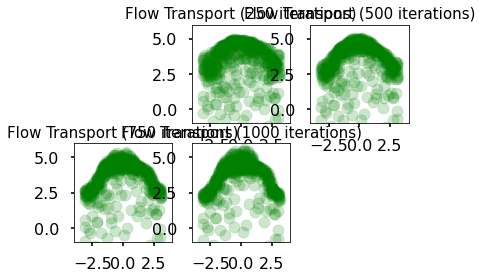

In [18]:
plt.subplot(2,3,2)
plt.title("Flow Transport (250 iterations)")
plt.scatter(*zip(*SamplesSaved[0]), color = 'g', alpha = 0.2)
plt.xlim(-4, 4)
plt.ylim(-1, 6)

plt.subplot(2,3,3)
plt.title("Flow Transport (500 iterations)")
plt.scatter(*zip(*SamplesSaved[1]), color = 'g', alpha = 0.2)
plt.xlim(-4, 4)
plt.ylim(-1, 6)

plt.subplot(2,3,4)
plt.title("Flow Transport (750 iterations)")
plt.scatter(*zip(*SamplesSaved[2]), color = 'g', alpha = 0.2)
plt.xlim(-4, 4)
plt.ylim(-1, 6)

plt.subplot(2,3,5)
plt.title("Flow Transport (1000 iterations)")
plt.scatter(*zip(*SamplesSaved[3]), color = 'g', alpha = 0.2)
plt.xlim(-4, 4)
plt.ylim(-1, 6)

plt.show()

In [19]:
X = torch.from_numpy(SamplesSaved[3])
Y = torch.from_numpy(CrescentSample)

Sigma = SigCalculation(SamplesSaved[3], CrescentSample)
MMD = MMDFunctions.mmd(X, Y, Sigma)
print("MMD Value:",MMD)
TestValue = MMDFunctions.TestThreshold(X, Y, Sigma)
print("Critical Value (5% Significance Level):",TestValue)

if MMD < TestValue:
    print("Null hypothesis not rejected, distributions are the same")
else:
    print("Null hypothesis rejected, distributions failed to be the same")

MMD Value: tensor(0.0031, dtype=torch.float64)


100%|██████████| 1000/1000 [00:17<00:00, 56.32it/s]

Critical Value (5% Significance Level): tensor(0.0059)
Null hypothesis not rejected, distributions are the same
